In [ ]:
!rm -r "/content/OpenEarthMap-Model-Training/"
!git clone https://github.com/raphi-web/OpenEarthMap-Model-Training.git

rm: cannot remove '/content/OpenEarthMap-Model-Training/': No such file or directory
Cloning into 'OpenEarthMap-Model-Training'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 62 (delta 29), reused 42 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 13.63 KiB | 1.95 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip '/content/drive/MyDrive/Colab Notebooks/Data/OpenEarthMap.zip' > unzip_logs.txt

In [ ]:
!pip install -q rasterio
!pip install -q segmentation-models-pytorch
!pip install -q lightning

!pip uninstall -q albumentations -y
!pip install -q albumentations # albumentationsx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys
sys.path.insert(1, '/content/OpenEarthMap-Model-Training')

In [ ]:
from dataset import Dataset
from augment import AugmentKind
from model import SegModel
from pathlib import Path
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from pytorch_lightning import callbacks
from pytorch_lightning import Trainer

In [ ]:
TRAIN_LIST = '/content/drive/MyDrive/Colab Notebooks/Data/OpenEarthMap/train.txt'
VAL_LIST = '/content/drive/MyDrive/Colab Notebooks/Data/OpenEarthMap/val.txt'
TEST_LIST = '/content/drive/MyDrive/Colab Notebooks/Data/OpenEarthMap/test.txt'
OEM_DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Data/OpenEarthMap'

classes = [1, 2, 3, 4, 5, 6, 7, 8]
batch_size = 4
epochs = 30
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
img_pths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/labels/" in str(f)]
img_pths = [f for f in img_pths if os.path.exists(str(f).replace("labels","images"))]

train_pths = [str(f) for f in img_pths if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_pths = [str(f) for f in img_pths if f.name in np.loadtxt(VAL_LIST, dtype=str)]
test_pths = [str(f) for f in img_pths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

In [ ]:
trainset = Dataset(train_pths, classes=classes,size=512, augment_kind=AugmentKind.HEAVY,train=True)
validset = Dataset(val_pths, classes=classes,size=512, augment_kind=AugmentKind.VALID)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
for data in train_loader:
    print("Train x:", data["x"].shape)
    print("Train y:", data["y"].shape)
    print("Train length:", len(trainset))
    break


for data in valid_loader:
    print("\nValid x:", data["x"].shape)
    print("Valid y:", data["y"].shape)
    print("Valid length:", len(validset))
    break


Train x: torch.Size([4, 3, 512, 512])
Train y: torch.Size([4, 9, 512, 512])
Train length: 2693

Valid x: torch.Size([4, 3, 512, 512])
Valid y: torch.Size([4, 9, 512, 512])
Valid length: 449


In [ ]:
INPUT_CHANNELS = 3

_model = smp.create_model(
            arch="Segformer",
            encoder_name="resnet34",
            encoder_weights="imagenet",
            decoder_segmentation_channels=512,
            in_channels=INPUT_CHANNELS,
            classes=len(classes) + 1,
        )

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
model = SegModel(
    model=_model,
    n_classes=len(classes)+1,
    learning_rate=1e-4,
    data_loader_len=len(train_loader),
    epochs=epochs,
    loss_type="advanced"
)

In [ ]:
checkpoint_callback = callbacks.ModelCheckpoint(dirpath='drive/MyDrive/Colab Notebooks')
early_stopping = callbacks.EarlyStopping('val_loss', patience=7)
trainer = Trainer(max_epochs=epochs, accelerator=device, callbacks=[early_stopping, checkpoint_callback])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, valid_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                 | Params | Mode
--------------------------------------------------------
0 | model   | Segformer            | 23.1 M | eval
1 | loss_fn | AdvancedCombinedLoss | 0      | eval
--------------------------------------------------------
23.1 M    Trainable params
0         Non-trainable params
23.1 M    Total params
92.512    Total estimated model params size (MB)
0         Modules in train mode
143       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict,"/content/drive/MyDrive/Colab Notebooks/Data/OpenEarthMap-Model.pth")

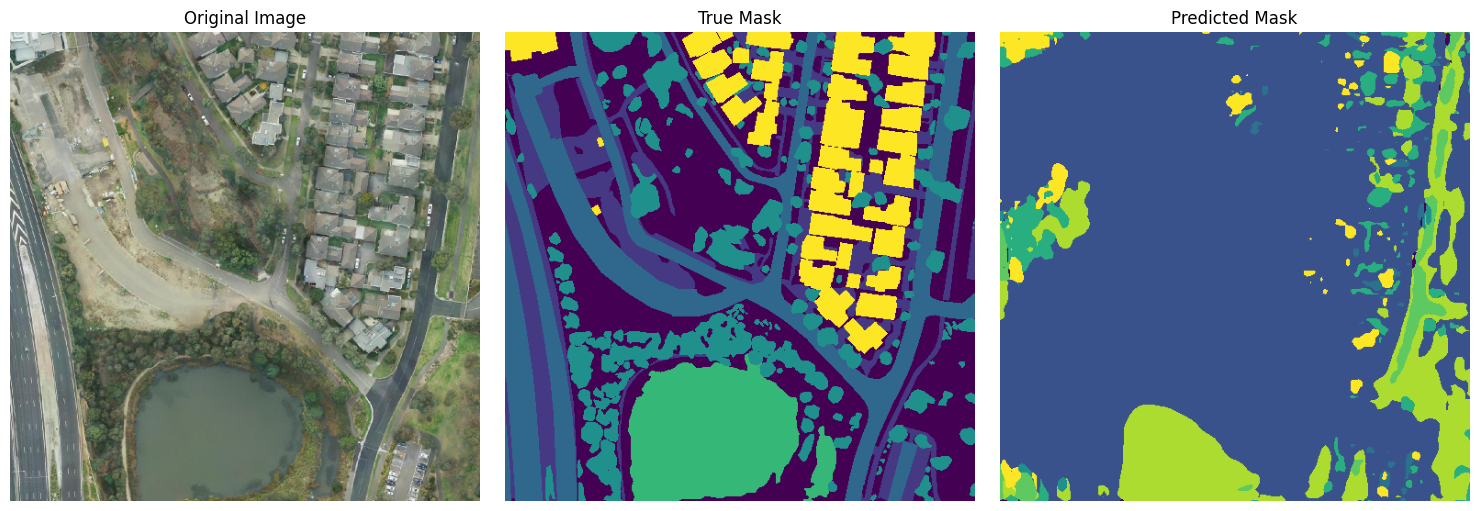

In [ ]:
import matplotlib.pyplot as plt
import random
import torch


sample_idx = random.randint(0, len(validset) - 1)
sample = validset[sample_idx]

image = sample["x"].permute(1, 2, 0).numpy()
mask = sample["y"].permute(1, 2, 0).numpy()


image_tensor = sample["x"].unsqueeze(0).to(device)

model.to(device)


model.eval()
with torch.no_grad():
    prediction = model(image_tensor)


predicted_mask = torch.argmax(prediction, dim=1).squeeze(0).cpu().numpy()


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")


true_mask_single_channel = np.argmax(mask, axis=-1)
axes[1].imshow(true_mask_single_channel, cmap='viridis') # Use a colormap suitable for masks
axes[1].set_title("True Mask")
axes[1].axis("off")

# Predicted Mask
axes[2].imshow(predicted_mask, cmap='viridis')
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()